# The Roommate Problem

You have a roommate, who never does the dishes. When your roommate cooks, they leave the kitchen dirty and you have to clean it. When your roomate doesn't cook, they eat out- which means the dishes are in the state you left them last.

You cook every night and you are tired of doing your roommates' dishes. What is the optimal strategy for doing as little work as possible?

## Analytical Approach

A straight forward approach- the loss function:

$$L = A \cdot [p + (1-p)\cdot (1 - x)] + B \cdot x\ \big|\ 0 \leq x \leq 1,\ A > B$$

Where

 - A: Cost of cleaning crusty plates
 - B: Cost of cleaning used plates
 - p: Chance your roommate cooks
 - x: The chance you will clean

$$\implies L = A\cdot p + (B - (1 - p)\cdot A) \cdot x\ \big|\ 0 \leq x \leq 1,\ A > B$$

**Notice** that $(B - (1 - p)\cdot A)$ determines whether negative or positive slope.

It follows:

 - Negative slope means don't wash up.
 - Positive slope means wash up.

$\therefore$ Wash up when $B > (1 - p)\cdot A$

In [1]:
""" Create globals and create fake data """
from math import ceil, sin, cos, pi
from random import random, shuffle, seed
import seaborn as sns
import numpy as np
import tensorflow as tf

# Loss values
washing = 1.0 # Basis
crusty  = washing * 2
# Change crusty to a large value like * 20, 
# and notice hueristic still works.
# The always and never lines are swapped however

# Set seed for determinism
seed(27)

# Some random function to generate data
# Creates inheirent underlying structure to data.
# Roommate washes or doesn't based on random()
# to this threshhold
def roommate(t, y, p):
    x = random()/10.0 - .05 # contributes 5%
    x += p * 0.05 # contributes 5%
    x += y * 0.20 # contributes 20%
    x += p * (.05 * sin(t/60.0) + .05) # contirbutes up to 10%
    x += (.1 * cos(t/300.0) + .1) # contirbutes up to 20%
    x += (.2 * cos(t/(7*pi)) + .2) # contirbutes up to 40%
    return x

# 6 years of training data
total = (365 * 6)
training = int(total * 2/3.0)

# init blank arrays
data = [0] * total
r = [0] * total
xs  = [(i > training/2) for i in range(training)]
ys = [0] * training

# shuffle ys for data stratification
shuffle(xs)

# Generate fake data
p = 0
q = 0
n = 0
m = 0

# Should have some how encapsulated this in Dishes, 
# but too late
for t in range(training):
    r[t] = roommate(t, xs[t], p)
    data[t] = random() < r[t]
    added = 0

    # Compute loss
    added = xs[t] * washing
    if data[t]:
        added += crusty

    ys[t] = -(added)**3

    n += xs[t]
    p = n/(t+1.0)
    m += (not data[t])
    q = m/(t+1.0)

# plot roommate distribution 
# sns.plt.plot(r)
# sns.plt.show()

In [2]:
""" Define the model """
# Assign for class scope
P = p
Q = q
M = m
N = n

# Model for running data
class Dishes():

    # bring precomputed values into scope
    def __init__(self):
        self.p = P
        self.q = Q
        self.n = N
        self.m = M
        self.mod = 1
        self.last = 0
        self.loss = [0] * int((ceil(total - training)/self.mod))
        self.count = 0

    # Run the model for a particular time step and choice
    def run(self, t, y):
        
        added = 0

        # Compute loss
        compute = True #(t % self.mod == 0)
        if(compute):
            added += y * washing
        else:
            self.last += y * washing

        # Check if dishes were dirty
        r[t] = roommate(t, y, self.p)
        data[t] = random() > r[t]

        # if the dishes are crusty
        if compute:
            if data[t]:
                added += crusty

            self.loss[self.count] = self.last + added
            self.last = self.loss[self.count]
            self.count += 1

        elif data[t]:
            self.last += crusty

        # update values
        self.n += y
        self.p = self.n/(t+1.0)
        self.m += (not data[t])
        self.q = self.m/(t+1.0)
        return self.loss, self.q, -(added)**3, data[t]

In [3]:
# Smart model

modelA = Dishes()
for t in range(training, total):
    y = washing < crusty * (1.0 - q)
    loss, q, _, _ = modelA.run(t, y)

sns.plt.plot(loss, label="smart");

In [4]:
# Never model

modelB = Dishes()
for t in range(training, total):
    y = 0
    loss, _, _, _ = modelB.run(t, y)

sns.plt.plot(loss, label = "never");

In [5]:
# Always model

modelC = Dishes()
for t in range(training, total):
    y = 1
    loss, _, _, _ = modelC.run(t, y)

sns.plt.plot(loss, label = "always");

In [6]:
# Random model

modelD = Dishes()
for t in range(training, total):
    y = 0.5 > random()
    loss, _, _, _ = modelD.run(t, y)

sns.plt.plot(loss, label = "random");

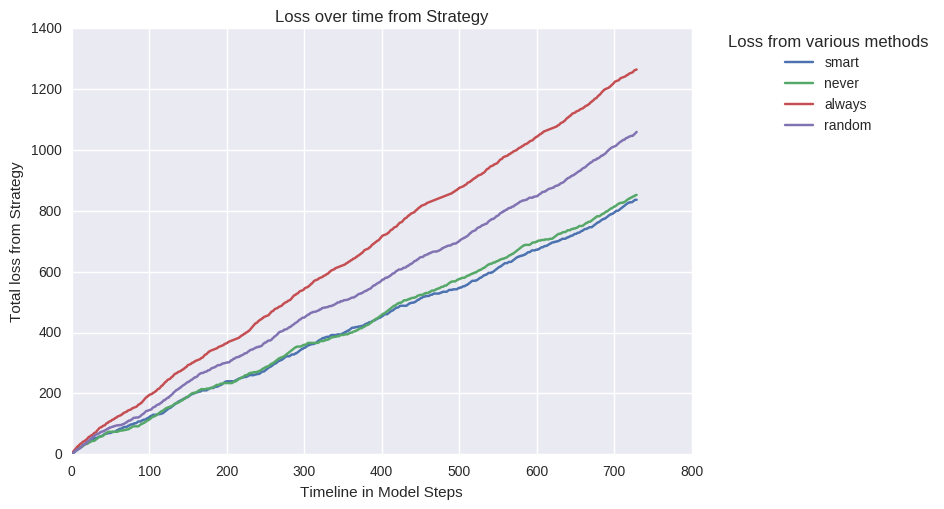

In [7]:
# Plot data
sns.plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Loss from various methods")
sns.plt.title("Loss over time from Strategy")
sns.plt.ylabel("Total loss from Strategy")
sns.plt.xlabel("Timeline in Model Steps")
sns.plt.show()

## Reality is a bit more complex

This model easily breaks. With large data sets, unresponsive to small changes.
Let's just throw a Q-Learning net at it*

\* Code derivative of https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0

In [ ]:
""" Create tensorflow graph with 64 nodes in hidden layer """
# Start graph templates
tf.reset_default_graph()
hidden = 64 # 64 just so I have a ton of values to show off
inputs = tf.placeholder(shape=[1,hidden],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([hidden,2],0,0.01)) # Weights
Qout = tf.matmul(inputs,W) # Relationship of inputs to i.e (1x64) x (64x2) = (1x2)
predict = tf.argmax(Qout,1) # Best choice of Qout

# Build loss relation for training
nextQ = tf.placeholder(shape=[1,2],dtype=tf.float32) # template for ideal Q value to compare to
loss = tf.reduce_sum(tf.square(nextQ - Qout)) # Least squared. Could play with
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.07) # Grab gradient and shift weights accordingly
updateModel = trainer.minimize(loss) # To minimize loss

# Create our numpy input layers
off = np.identity(hidden)[False:False+1]
on = np.identity(hidden)[True:True+1]
switch = [off, on]
s = off

init = tf.global_variables_initializer()

# Set learning parameters
y = .99
model = Dishes()

# Hold on to reward per action for debugging
d=[]

# The Q-Network
with tf.Session() as sess:
    writer = tf.summary.FileWriter("graph", sess.graph) # Just for the viz
    sess.run(init)
    
    # Iterate through all points
    for t in range(total):

        # default choice
        choice = 0
        
        # Choose an action from the Q-network
        a, allQ = sess.run([predict,Qout],feed_dict={inputs:s})
        
        # For training rely on generated data
        if t < training:
            R = ys[t]
            n = data[t]
            choice = xs[t] * 1

        # Use the Q-train choice
        else:
            choice = a[0]
            # Get new state and reward from environment
            _, q, R, n = model.run(t, choice)

        # record reward
        d.append(R)
            
        # Create input layer
        nxt = switch[n]
        nxt[0,2] = (t % 7)/2.
        nxt[0,3] = n
        nxt[0,4] = model.q
        
        # Obtain the Q' values by feeding the new state through our network
        # i.e the ideal state
        Q1 = sess.run(Qout,feed_dict={inputs:nxt})

        # Obtain maxQ' and set our target value for chosen action.
        maxQ1 = np.max(Q1)
        targetQ = allQ
        targetQ[0,choice] = R + y * maxQ1

        # Train our network using target and predicted Q values
        _,W1 = sess.run([updateModel,W],feed_dict={inputs:s, nextQ:targetQ})

        s = nxt

    # Save data for viz
    print("Resultant Weights:")
    #print(W.eval())
    saver = tf.train.Saver()
    saver.save(sess, "model.ckpt")

writer.close()

# Check that reward actually increases
# sns.plt.plot(d);
# sns.plt.show()

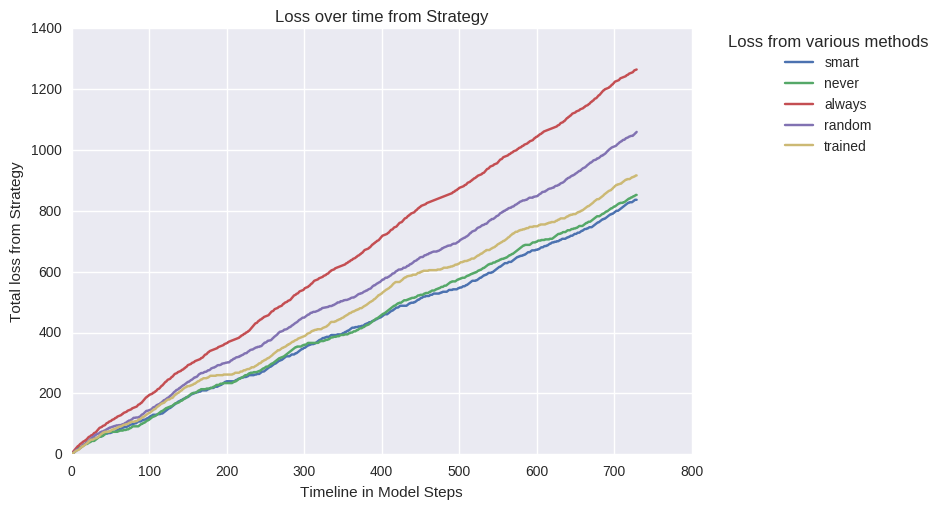

In [9]:
# Plot it all
sns.plt.plot(modelA.loss, label = "smart");
sns.plt.plot(modelB.loss, label = "never");
sns.plt.plot(modelC.loss, label = "always");
sns.plt.plot(modelD.loss, label = "random");
sns.plt.plot(model.loss, label = "trained");
sns.plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Loss from various methods")
sns.plt.title("Loss over time from Strategy")
sns.plt.ylabel("Total loss from Strategy")
sns.plt.xlabel("Timeline in Model Steps")
sns.plt.show()